In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MODEL_SAVE_PATH = '/content/gdrive/My Drive/Colab Notebooks/dacon_12/model_save/'
USER = "laphisboy"

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Feb 13 21:06:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
pip install git+https://github.com/laphisboy/pytorch-image-models.git

  Cloning https://github.com/laphisboy/pytorch-image-models.git to /tmp/pip-req-build-dlq52var
  Running command git clone -q https://github.com/laphisboy/pytorch-image-models.git /tmp/pip-req-build-dlq52var
  Created wheel for timm: filename=timm-0.4.2-cp36-none-any.whl size=266018 sha256=5bf877183cb2e8ea1a9a96e602125156493ab91b830abe2c8f899fc095164acf
  Stored in directory: /tmp/pip-ephem-wheel-cache-nfhr6cji/wheels/61/8c/86/d8837b09a6d24d66496d9612389e2b244f129d1083286ab198
Successfully built timm


In [ ]:
pip install antialiased-cnns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import imutils
import zipfile
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from google.colab import output

from sklearn.model_selection import KFold

import timm
import antialiased_cnns
from antialiased_cnns import BlurPool
import re

import torchvision

import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def random_padding(pad_x, pad_y):
    pad_x1 = pad_x
    pad_x2 = 228 - pad_x 

    pad_y1 = pad_y
    pad_y2 = 228 - pad_y

    return (pad_x1, pad_y1, pad_x2, pad_y2)

In [ ]:
train_set = torchvision.datasets.EMNIST(
    root = './data/EMNIST',
    split = 'letters',
    train = True,
    download = True,
    transform = T.Compose([
        T.ToTensor() ,
        T.Normalize(0.1722, 0.3242),
    ])
)
test_set = torchvision.datasets.EMNIST(
    root = './data/EMNIST',
    split = 'letters',
    train = False,
    download = True,
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(0.1722, 0.3242)
    ])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16)

# mean = tensor([0.1722])
# std = tensor([0.3242])

Extracting ./data/EMNIST/EMNIST/raw/emnist.zip to ./data/EMNIST/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [ ]:

#dirty_mnist_answer = pd.read_csv(DIRTY_MNIST_ANSWER_PATH)

In [ ]:
#namelist = os.listdir(DIRTY_MNIST_PATH)

In [ ]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()

torch.Size([16, 1, 256, 256])


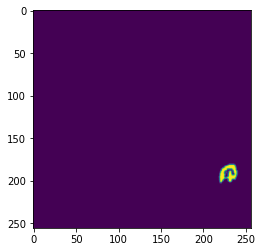

In [ ]:
it= iter(train_loader)
image, label= next(it)
image = T.functional.pad(image, padding=random_padding(random.randint(10,218), random.randint(10,218)) ,padding_mode="edge")
print(np.squeeze(image, axis=0).shape)
imshow(np.squeeze(image)[1])

torch.Size([16, 1, 28, 28])


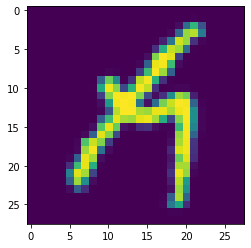

In [ ]:
image, label= next(it)
print(np.squeeze(image, axis=0).shape)
imshow(np.squeeze(image)[1])

torch.Size([16, 1, 28, 28])


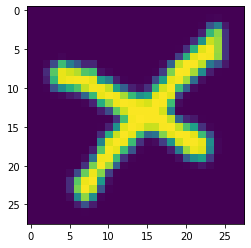

In [ ]:
image, label= next(it)
print(np.squeeze(image, axis=0).shape)
imshow(np.squeeze(image)[1])

In [ ]:
def search(child,depth):

    str_child = str(child)

    if re.search(':' ,str_child)!=None:
        return None
    else:
        if re.search('Conv2d', str_child)!=None:
            if re.search('stride=\(2, 2\)', str_child)!=None:
                print(depth, str_child)

In [ ]:
"""
mean = 0.
std = 0.
nb_samples = 0.

for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'mean = {mean}')
print(f'std = {std}')
"""

# mean = tensor([0.1722])
# std = tensor([0.3242])

"\nmean = 0.\nstd = 0.\nnb_samples = 0.\n\nfor data, _ in train_loader:\n    batch_samples = data.size(0)\n    data = data.view(batch_samples, data.size(1), -1)\n    mean += data.mean(2).sum(0)\n    std += data.std(2).sum(0)\n    nb_samples += batch_samples\n\nmean /= nb_samples\nstd /= nb_samples\n\nprint(f'mean = {mean}')\nprint(f'std = {std}')\n"

In [ ]:

# nn.Module을 상속 받아 MultiLabelResnet를 정의
class MultiLabelAntiEfficientNet(nn.Module):
    def __init__(self):
        super(MultiLabelAntiEfficientNet, self).__init__()
        #self.conv2d = nn.Conv2d(1, 3, 3, stride=1)
        self.model = timm.create_model('tf_efficientnet_b4_ns', pretrained=False)
        self.model.conv_stem = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 26)

    def forward(self, x):
        # resnet의 입력은 [3, N, N]으로
        # 3개의 채널을 갖기 때문에
        # resnet 입력 전에 conv2d를 한 층 추가
        #x = F.relu(self.conv2d(x))

        # resnet18을 추가
        # = F.relu(self.model(x))

        # 마지막 출력에 nn.Linear를 추가
        # multilabel을 예측해야 하기 때문에
        # softmax가 아닌 sigmoid를 적용
        x = self.model(x)
        return x
# 모델 선언
#model = MultiLabelAntiEfficientNet()


In [ ]:
#model.to(device)

In [ ]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.0f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

In [ ]:
def annot_min(x,y, ax=None):
    xmax = x[np.argmin(y)]
    ymax = y.min()
    text= "x={:.0f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

In [ ]:
"""
#######################
# baseline
#######################

MODEL = 'antiefficient'
PRETRAINED = 'EMNISTletter'
path = MODEL_SAVE_PATH

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []
    
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=5,
                                            gamma=0.75)

criterion = torch.nn.CrossEntropyLoss()

valid_acc_max = 0

for epoch in range(30):
    train_acc_list = []

    with tqdm(train_loader,
            total=train_loader.__len__(),
            unit="batch") as train_bar:
        for images, labels in train_bar:
            images = T.functional.pad(images, padding=random_padding(random.randint(10,218), random.randint(10,218)) ,padding_mode="edge")
            train_bar.set_description(f'Train Epoch {epoch}')
            
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)
            labels -= 1

            model.train()

            with torch.set_grad_enabled(True):

                probs = model(images)

                loss = criterion(probs, labels)

                loss.backward()

                optimizer.step()

                probs = probs.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()

                batch_acc = (labels == probs.argmax(axis=1)).mean()
                train_acc_list.append(batch_acc)
                train_loss_list.append(loss.item())
                train_acc = np.mean(train_acc_list)
            train_bar.set_postfix(train_loss=loss.item(),
                                train_acc=train_acc)
            
    train_loss_list2.append(sum(train_loss_list) / len(train_loader))
    train_acc_list2.append(sum(train_acc_list) / len(train_loader))

    train_loss_list = []
    train_acc_list = []
            
    
    valid_acc_list = []
    with tqdm(test_loader,
            total=test_loader.__len__(),
            unit='batch') as valid_bar:
        for images, labels in valid_bar:
            images = T.functional.pad(images, padding=random_padding(random.randint(10,218), random.randint(10,218)) ,padding_mode="edge")
            valid_bar.set_description(f'Valid Epoch {epoch}')
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)
            labels -=1

            model.eval()

            with torch.no_grad():
                
                probs = model(images)
                valid_loss = criterion(probs, labels)

                probs = probs.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()
                batch_acc = (labels == probs.argmax(axis=1)).mean()
                valid_acc_list.append(batch_acc)

            valid_acc = np.mean(valid_acc_list)
            valid_loss_list.append(valid_loss.item())
            valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                valid_acc=valid_acc)
            
    valid_loss_list2.append(sum(valid_loss_list) / len(test_loader))
    valid_acc_list2.append(sum(valid_acc_list) / len(test_loader))

    valid_loss_list = []
    valid_acc_list = []
            
    lr_scheduler.step()

    if valid_acc_max < valid_acc:
        valid_acc_max = valid_acc
        best_model = model
        torch.save(best_model, f'{path}{USER}_{MODEL}_{PRETRAINED}.pth')
        """

Train Epoch 4:  62%|██████▏   | 4853/7800 [25:37<15:34,  3.15batch/s, train_acc=0.93, train_loss=0.116]

In [ ]:
#######################
# baseline
#######################

MODEL = 'antiefficient'
PRETRAINED = 'EMNISTletter'
path = MODEL_SAVE_PATH

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

model = torch.load(f'{path}{USER}_{MODEL}_{PRETRAINED}_epoch_9.pth')
    
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=5,
                                            gamma=0.75)

criterion = torch.nn.CrossEntropyLoss()

valid_acc_max = 0



for epoch in range(30):
    train_acc_list = []

    with tqdm(train_loader,
            total=train_loader.__len__(),
            unit="batch") as train_bar:
        for images, labels in train_bar:
            images = T.functional.pad(images, padding=random_padding(random.randint(10,218), random.randint(10,218)) ,padding_mode="edge")
            train_bar.set_description(f'Train Epoch {epoch}')
            
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)
            labels -= 1

            model.train()

            with torch.set_grad_enabled(True):

                probs = model(images)

                loss = criterion(probs, labels)

                loss.backward()

                optimizer.step()

                probs = probs.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()

                batch_acc = (labels == probs.argmax(axis=1)).mean()
                train_acc_list.append(batch_acc)
                train_loss_list.append(loss.item())
                train_acc = np.mean(train_acc_list)
            train_bar.set_postfix(train_loss=loss.item(),
                                train_acc=train_acc)
            
    train_loss_list2.append(sum(train_loss_list) / len(train_loader))
    train_acc_list2.append(sum(train_acc_list) / len(train_loader))

    train_loss_list = []
    train_acc_list = []
            
    
    valid_acc_list = []
    with tqdm(test_loader,
            total=test_loader.__len__(),
            unit='batch') as valid_bar:
        for images, labels in valid_bar:
            images = T.functional.pad(images, padding=random_padding(random.randint(10,218), random.randint(10,218)) ,padding_mode="edge")
            valid_bar.set_description(f'Valid Epoch {epoch}')
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.to(device)
            labels -=1

            model.eval()

            with torch.no_grad():
                
                probs = model(images)
                valid_loss = criterion(probs, labels)

                probs = probs.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()
                batch_acc = (labels == probs.argmax(axis=1)).mean()
                valid_acc_list.append(batch_acc)

            valid_acc = np.mean(valid_acc_list)
            valid_loss_list.append(valid_loss.item())
            valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                valid_acc=valid_acc)
            
    valid_loss_list2.append(sum(valid_loss_list) / len(test_loader))
    valid_acc_list2.append(sum(valid_acc_list) / len(test_loader))

    valid_loss_list = []
    valid_acc_list = []
            
    lr_scheduler.step()

    if valid_acc_max < valid_acc:
        valid_acc_max = valid_acc
        best_model = model
        torch.save(best_model, f'{path}{USER}_{MODEL}_{PRETRAINED}.pth')

Train Epoch 15:  91%|█████████ | 7061/7800 [32:32<03:23,  3.63batch/s, train_acc=0.964, train_loss=0.0694]

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

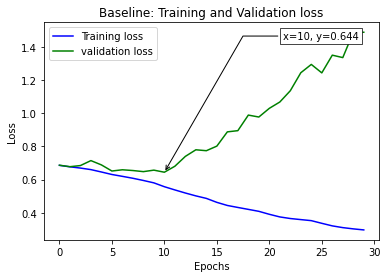

In [ ]:
epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

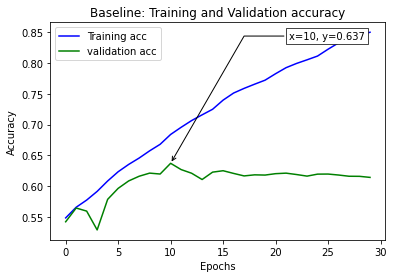

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# normalzation
#######################

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []


    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:15<00:00, 19.82batch/s, valid_acc=0.614, valid_loss=1.37]

[fold: 2]


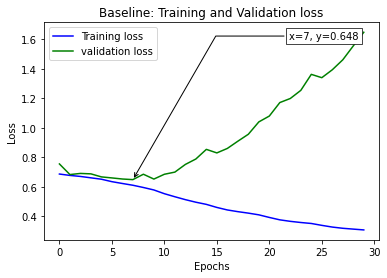

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

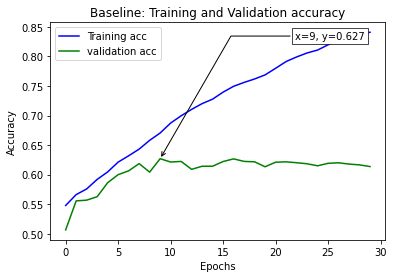

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

In [ ]:
##################################################################################################
##################################################################################################
##################################################################################################

In [ ]:
#######################
# SpinalNet
# RandomRotation 10
# RandompPerspective (might want to set distortion scale 0.2 or smaller later on)
# with normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.RandomPerspective(0.2),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])


kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:15<00:00, 20.05batch/s, valid_acc=0.609, valid_loss=1.36]

[fold: 2]


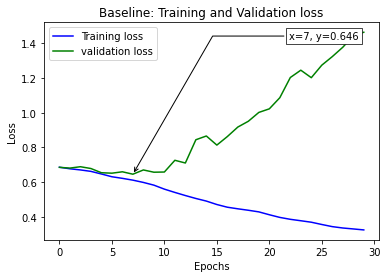

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

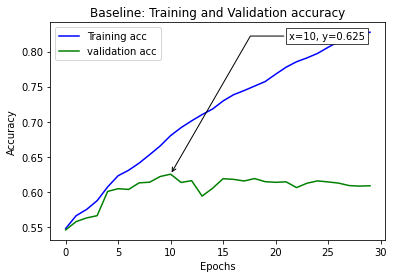

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# SpinalNet
# RandomRotation 10
# RandompPerspective (might want to set distortion scale 0.2 or smaller later on)
# without normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.RandomPerspective(0.2),
                             T.ToTensor()
])
eval_transform = T.Compose([
                             T.ToTensor()
])


kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:15<00:00, 19.94batch/s, valid_acc=0.608, valid_loss=1.31]

[fold: 2]


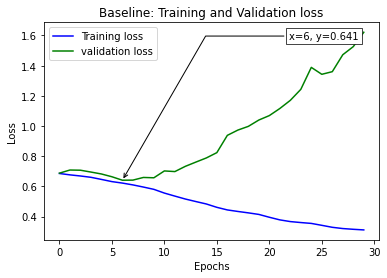

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

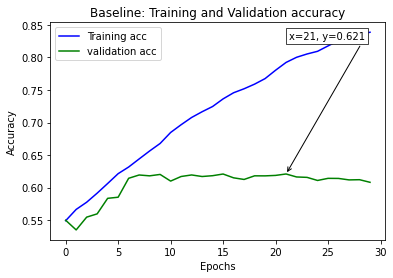

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# SpinalNet
# RandomRotation 10
# no RandomPerspective
# with normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])


kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:13<00:00, 23.86batch/s, valid_acc=0.612, valid_loss=1.09]


[fold: 2]


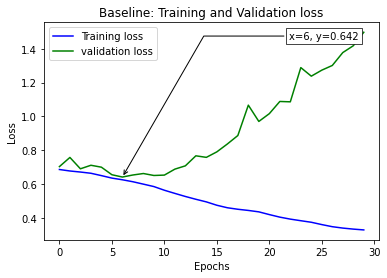

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

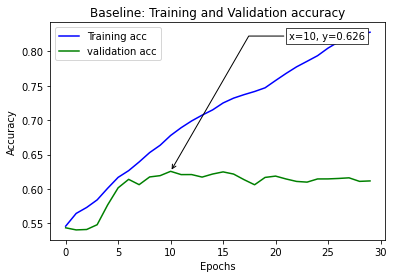

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# SpinalNet
# RandomRotation 10
# no RandomPerspective
# no normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.ToTensor(),
])
eval_transform = T.Compose([
                             T.ToTensor(),
])


kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:13<00:00, 23.03batch/s, valid_acc=0.623, valid_loss=1.52]

[fold: 2]


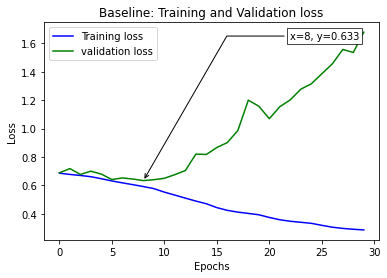

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

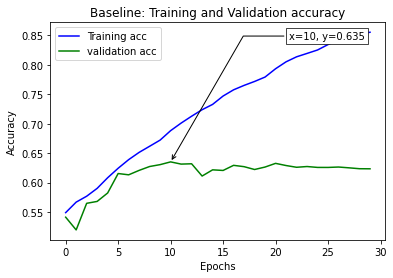

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# 30 epochs 1 fold
# SpinalNet
# RandomRotation 90
# RandompPerspective
# with normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=90),
                             T.RandomPerspective(0.2),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:13<00:00, 23.33batch/s, valid_acc=0.609, valid_loss=1.03]


[fold: 2]


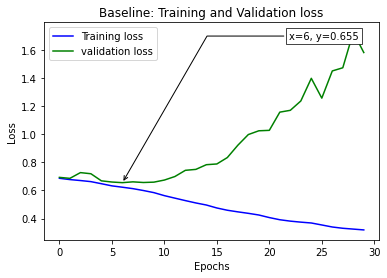

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

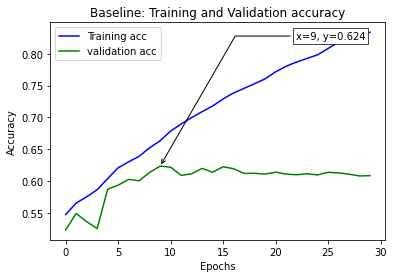

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# 20 epochs 1 fold
# SpinalNet
# RandomRotation 180
# RandompPerspective
# with normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=180),
                             T.RandomPerspective(0.2),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007)
])
eval_transform = T.Compose([
                            T.ToTensor(),
                            T.Normalize(0.5350, 0.3007)
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:13<00:00, 23.60batch/s, valid_acc=0.613, valid_loss=1.17]


[fold: 2]


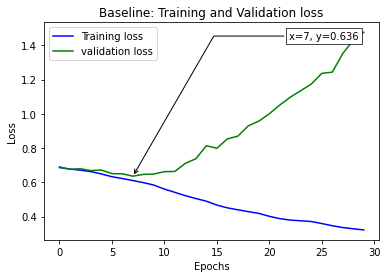

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

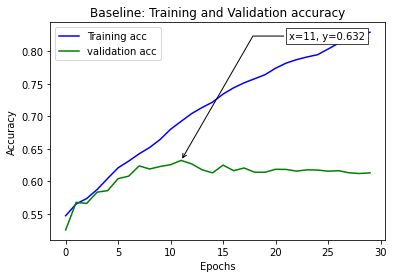

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
##################################################################################################
##################################################################################################
##################################################################################################

In [ ]:
#######################
# Efficient Capsnet
# RandomRotation 30
# Translation 2pixel for 28x28 image - x, y translation is independent [p=0.5]
# Width Compression 0 ~ 25%
# Random Erasure 4x4 for 28x28 (20x20)
#
# what i implemented:
# RandomRotation30
# RandomAffine - translation -10% ~ 10% of image size in x and y direction
# Resize only compress width from 256 to 220
# Pad right and left of image to make 256 256
# RandomErasing 1% ~ 2% of image with a square (p=0.5)
# Normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=30),
                             T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                             T.Resize((256, 220)),
                             T.Pad((18,0)),
                             T.ToTensor(),
                             T.RandomErasing(scale=(0.01, 0.02), ratio=(1,1)),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# Efficient Capsnet
# RandomRotation 30
# Translation 2pixel for 28x28 image - x, y translation is independent [p=0.5]
# Width Compression 0 ~ 25%
# Random Erasure 4x4 for 28x28 (20x20)
#
# what i implemented:
# RandomRotation30
# RandomAffine - translation -10% ~ 10% of image size in x and y direction
# Resize only compress width from 256 to 220
# Pad right and left of image to make 256 256
# RandomErasing 1% ~ 2% of image with a square (p=0.5) x 3 times
# Normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=30),
                             T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                             T.Resize((256, 220)),
                             T.Pad((18,0)),
                             T.ToTensor(),
                             T.RandomErasing(scale=(0.01, 0.02), ratio=(1,1)),
                             T.RandomErasing(scale=(0.01, 0.02), ratio=(1,1)),
                             T.RandomErasing(scale=(0.01, 0.02), ratio=(1,1)),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
# done for today

In [ ]:
#######################
# baseline
#######################

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 2:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, train_transform)
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, eval_transform)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(10):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        lr_scheduler.step()

        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            torch.save(best_model, f'{path}{USER}_{fold_index}_{MODEL}.pth')
    best_models.append(best_model)



[fold: 1]


Valid Epoch 0: 100%|██████████| 313/313 [00:25<00:00, 12.22batch/s, valid_acc=0.486, valid_loss=0.729]


NameError: ignored